In [1]:
%matplotlib inline

# Import Dependencies

In [2]:
# Data Wrangling
import os
from google.colab import drive

# Data Analysis
import numpy as np
import pandas as pd
from math import ceil
from sklearn.manifold import TSNE

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# ML
import torch
from torch.utils.data import Dataset, DataLoader

# Huggingface
%pip install transformers
from transformers import BertConfig, BertModel

# Miscellaneous
from typing import List

     |████████████████████████████████| 3.4 MB 33.1 MB/s 
     |████████████████████████████████| 895 kB 58.3 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 61 kB 423 kB/s 
     |████████████████████████████████| 3.3 MB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Set Hyperparameters

In [3]:
batch_size = 16
epoch = 1

# Data Exploration

Mount our Google Drive to this Colab instance, as if it were a local file system, and switch to the directory where the data are stored.

In [4]:
drive._mount('/content/drive')
%cd '/content/drive/MyDrive/Research/Ongoing/Dynamic Spectra Sequence Modeling/Data'

Mounted at /content/drive
/content/drive/MyDrive/Research/Ongoing/Dynamic Spectra Sequence Modeling/Data


In [5]:
%ls

Figures/  masked_labels.csv  sample_submission.csv  train/
Kaggle/   Results/           test/                  train_labels.csv


Here, we have five items of interest:


* `train/` - a training set of cadence snippet files stored in `numpy` `float16` format (v1.20.1), one file per cadence snippet id, with corresponding labels found in the `train_labels.csv` file. Each file has dimension `(6, 273, 256)`, with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram, i.e. frequency as a function of time.
* `test/` - the test set cadence snippet files; our goal is to predict whether or not the cadence contains a "needle".
* `train_labels.csv` - targets corresponding (by id) to the cadence snippet files found in the `train/` folder (1 if cadence contains a "needle", 0 if not).
* `sample_submission.csv` - a sample submission file in the correct format.
* `masked_labels.csv` - **[NOTE: I FORGOT WHAT THIS IS, ASK YUHONG]**




Read in both csv files into a `pd.DataFrame`, and check for any missing values.

In [6]:
df_train = pd.read_csv('train_labels.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [7]:
df_train.shape

(60000, 2)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  object
 1   target  60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB


In [9]:
df_test = pd.read_csv('sample_submission.csv')
df_test.head()

,id,target
0,000bf832cae9ff1,0.5
1,000c74cc71a1140,0.5
2,000f5f9851161d3,0.5
3,000f7499e95aba6,0.5
4,00133ce6ec257f9,0.5


In [10]:
df_test.shape

(39995, 2)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39995 entries, 0 to 39994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      39995 non-null  object 
 1   target  39995 non-null  float64
dtypes: float64(1), object(1)
memory usage: 625.0+ KB


# Feature Engineering

Since there are no missing values to handle, collect the filepaths to each of the 60,000 train cadence snippets, and the 39,995 test cadence snippets, using `os.walk()`.

In [12]:
train_filepaths, test_filepaths = [], []

for root, dirs, files in os.walk('train'):
  for filename in files:
    train_filepaths.append(os.path.join(root, filename))

for root, dirs, files in os.walk('test'):
  for filename in files:
    test_filepaths.append(os.path.join(root, filename))

# Verify that we have the expected number of filepaths
print(f'train: {len(train_filepaths)}\ntest: {len(test_filepaths)}')

train: 60000
test: 39995


Construct a new `pd.DataFrame` with "Filepath" included alongside "ID" and "Target".


In [13]:
# Strip the ID from each filepath
train_id = [path[8:-4] for path in train_filepaths]
test_id = [path[7:-4] for path in test_filepaths]

# Look up target values from the previous DataFrame using ID values
train_target = [df_train.loc[df_train['id'] == id]['target'].values[0] for _, id in tqdm(enumerate(train_id), total=60000)]
test_target = [df_test.loc[df_test['id'] == id]['target'].values[0] for _, id in tqdm(enumerate(test_id), total=39995)]

# Verify that we have the expected number of IDs and targets
print(f'train: {len(train_id)}, {len(train_target)}\ntest: {len(test_id)}, {len(test_target)}')

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/39995 [00:00<?, ?it/s]

train: 60000, 60000
test: 39995, 39995


In [14]:
df_train = pd.DataFrame({'Filepath': train_filepaths,
                         'ID': train_id,
                         'Target': train_target})
df_train.head()

,Filepath,ID,Target
0,train/d/db805c5b0201ffd.npy,db805c5b0201ffd,0
1,train/d/db72b5d462d6dd4.npy,db72b5d462d6dd4,0
2,train/d/db77389bd6ab27f.npy,db77389bd6ab27f,0
3,train/d/db7c72aad96f575.npy,db7c72aad96f575,0
4,train/d/db7ea5d75980af2.npy,db7ea5d75980af2,0


In [15]:
df_test = pd.DataFrame({'Filepath': test_filepaths,
                        'ID': test_id,
                        'Target': test_target})
df_test.head()

,Filepath,ID,Target
0,test/9/99d159554adf56a.npy,99d159554adf56a,0.5
1,test/9/99b96f0033882f1.npy,99b96f0033882f1,0.5
2,test/9/99bce84b9aeb210.npy,99bce84b9aeb210,0.5
3,test/9/99c04284d16acf1.npy,99c04284d16acf1,0.5
4,test/9/99d7868c21e1ce1.npy,99d7868c21e1ce1,0.5


Finally, read in a single cadence snippet using `np.load()`, and check that its dimensions are indeed `(6, 273, 256)`.

In [16]:
ndarray = np.load(df_train['Filepath'][0])
ndarray.shape

(6, 273, 256)

# Dataset & DataLoader

Here we create a custom object with inheritance from PyTorch's `Dataset` class, to retrieve our data’s samples and corresponding labels, one at a time.

In [17]:
class KaggleDataset(Dataset):
  def __init__(self, 
               paths: List[str], 
               ids: List[str],
               labels: List[int], 
               transform=None,
               id_transform=None,
               label_transform=None):
    '''
    The __init__ function is called when you instantiate the class.

    Args:
    - self: the instance of the class.
    - paths: list of paths to the data, which are each cadence snippet files stored in np.float16 format, with dimensions (6, 273, 256).
    - ids: list of snippet IDs to the cadence snippet files.
    - labels: list of snippet labels to the cadence snippet files (1 if cadence contains a "needle", 0 if not).
    - transform: optional transformation to be performed on a cadence snippet.
    - id_transform: optional transformation to be performed on a snippet id.
    - label_transform: optional transformation to be performed on a snippet label.
    '''
    self.paths = paths
    self.ids = ids
    self.labels = labels
    self.transform = transform
    self.id_transform = id_transform
    self.label_transform = label_transform

  def __len__(self) -> int:
    '''
    The __len__ function returns the number of samples in our dataset.
    '''
    return len(self.ids)

  def __getitem__(self, 
                  idx: int) -> (np.array, str, int):
    '''
    The __getitem__ function loads a cadence snippet from the dataset at the given index,
    retrieves the corresponding id and label, calls the transform functions on them (if provided), 
    and returns all three values as a tuple.
    '''
    ndarray = np.load(self.paths[idx])
    id = self.ids[idx]
    label = self.labels[idx]
    if self.transform:
      ndarray = self.transform(ndarray)
    if self.id_transform:
      id = self.id_transform(id)
    if self.label_transform:
      label = self.label_transform(label)
    return ndarray, id, label

In [18]:
train_data = KaggleDataset(paths=df_train['Filepath'].tolist(), 
                           ids=df_train['ID'].tolist(),
                           labels=df_train['Target'].tolist())

test_data = KaggleDataset(paths=df_test['Filepath'].tolist(), 
                          ids=df_test['ID'].tolist(),
                          labels=df_test['Target'].tolist())

During training, we want to pass the cadence snippets in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval. `DataLoader` is an iterable that abstracts this complexity for us in an easy API.

In [19]:
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

Now that we've loaded the data into the `DataLoader` and can iterate through the dataset as needed, each iteration below returns a batch of `train_snippets`, `train_ids`, and `train_labels` (containing `batch_size=16` snippets, IDs, and labels, respectively). Note that because we specified `shuffle=True`, after we iterate over all batches, the data is shuffled.

In [20]:
# Since torch.Tensor doesn't support strings, train_ids is returned as a tuple, which we'll immediately convert into an ndarray
train_snippets, train_ids, train_labels = next(iter(train_dataloader))
train_ids = np.asarray(train_ids)

# Verify that the dimensions are in agreement with expectations
print(f'Snippets batch shape: {train_snippets.shape}')
print(f'IDs batch shape: {train_ids.shape}')
print(f'Labels batch shape: {train_labels.shape}')

Snippets batch shape: torch.Size([16, 6, 273, 256])
IDs batch shape: (16,)
Labels batch shape: torch.Size([16])


Let's try visualizing one of the cadence snippets.

In [21]:
# Define function to plot samples (expected input: ndarray of shape [6, 273, 256])
def plot_cadence_snippet(cad_snippet, title=None):
    cad_snippet = cad_snippet.astype('float32')
    num_obs, h, w = cad_snippet.shape
    fig, axes = plt.subplots(6, 1, figsize=(10, 5))
    axes = axes.flatten()
    if title:
        fig.suptitle(title)
    for i in range(6):
        axes[i].imshow(cad_snippet[i])
        axes[i].axis('off')
        axes[i].set_aspect("auto")
    plt.show()

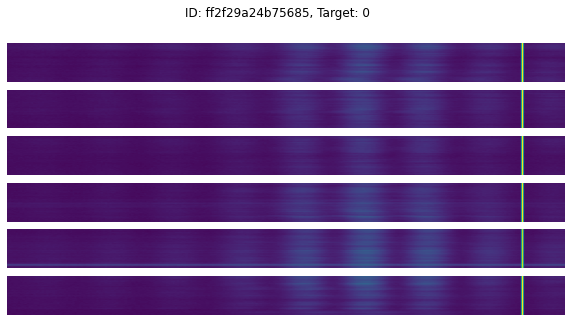

In [22]:
snippet, title = train_snippets[0].numpy(), f'ID: {train_ids[0]}, Target: {train_labels[0]}'
plot_cadence_snippet(snippet, title)

# Data Preprocessing

For preprocessing, we perform the following transformations:


1.   Dimensionality reduction: since the BERT model only takes 2-dimensional inputs, we concatenate the cadence snippets pointing-wise, i.e. from `(6, 273, 256)` to `(1638, 256)`.
2.   Downsampling: due to BERT's size limit of `512`, we downsample the time-axis by a factor of 4. **[NOTE: SINCE 1638 IS NOT DIVISIBLE BY 4, SWITCH TO USING LINEAR INTERPOLATION]**



In [23]:
def preprocessing(snippets: torch.Tensor,
                  batch_size: int) -> torch.Tensor:
  '''
  Preprocessing for the Kaggle dataset, which consists of dimensionality reduction + downsampling.

  Args:
  - snippets: a tensor of shape (batch_size, 1638, 256) that contains the cadence snippets.
  - batch_size: the number of snippets we want to process at once.

  Returns: 
  The preprocessed snippets.
  '''
  # Create a temporary tensor with the expected output size
  tmp = torch.zeros(batch_size, 410, 256)
  # Loop over each snippet and apply the appropriate preprocessing steps
  for idx, snippet in enumerate(snippets):
    snippet = snippet.reshape((1638, 256))
    snippet = snippet[::4, :]
    # Save the result to the temporary tensor
    tmp[idx] = snippet
  return tmp

In [24]:
# Apply the preprocessing steps to the cadence snippets
train_snippets = preprocessing(train_snippets, batch_size)
# Verify that the resulting dimensions are consistent with expectations
train_snippets.shape

torch.Size([16, 410, 256])

# Perform Inference

Using [HuggingFace](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel)'s pre-trained BERT model, we perform inference on the cadence snippets in batches.

In [25]:
# Initializing a custom BERT configuration, where the number of attention heads must be a multiple of the hidden size
configuration = BertConfig(hidden_size=256, num_attention_heads=16)

# Initializing a model from the custom BERT configuration
model = BertModel(configuration)

# Forward pass of the model
outputs = model.forward(inputs_embeds=train_snippets)

# Collect the final classification tokens
pooler_outputs = outputs.pooler_output

# Verify that the resulting dimensions are as expected
pooler_outputs.shape

torch.Size([16, 256])

All that's left is to feed in all of the available data into the model. With readibility in mind, we define a pipeline that includes preprocessing, inference, and postprocessing.

In [26]:
def pipeline(data, model, batch_size, outpath):
  '''
  A pipeline to perform inference on the Kaggle dataset, consisting of preprocessing, inference, and postprocessing.

  Args:
  - data: the dataset to be used, which includes filepaths to the cadence snippets, and their corresponding IDs and labels
  - model: the model that will be used for inference
  - batch_size: the number of samples to be processed in parallel
  - outpath: the path to the directory where the outputs will be saved
  '''
  # Load the data into the DataLoader
  loader = DataLoader(data, batch_size, shuffle=True)
  # Wrap an iterator around the DataLoader
  iterator = iter(loader)
  # Disable gradient calculations to free up memory for inference
  with torch.no_grad():
    # Loop through the entire dataset, where if len(data) is not divisible by batch_size, the final iteration will have a reduced number of samples
    for i in tqdm(range(ceil(len(data) / batch_size))):
      # Read in the cadence snippets, as well as the corresponding IDs and labels
      snippets, ids, labels = next(iterator)
      # Perform preprocessing on the snippets
      snippets = preprocessing(snippets, batch_size)
      # Perform inference on the snippets from the forward pass of the model
      outputs = model.forward(inputs_embeds=snippets)
      # Collect the final classification tokens
      pooler_outputs = outputs.pooler_output
      # Save the outputs as .npy files in a separate directory
      for idx, val in enumerate(pooler_outputs):
        np.save(f'{outpath}{ids[idx]}_(1)', val.detach().numpy())

In [27]:
pipeline(data=train_data, 
         model=model, 
         batch_size=batch_size, 
         outpath='Results/')

  0%|          | 0/3750 [00:00<?, ?it/s]

# Data Visualization

We perform t-SNE ([t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) on the pooler outputs to visualize the model's latent space in 2-dimensions.

In [28]:
# Load back in the data from our Results directory
filepaths, id = [], []
data = np.ndarray((60000, 256))

for root, dirs, files in os.walk('Results'):
  for filename in files:
    filepaths.append(os.path.join(root, filename))
for _, path in tqdm(enumerate(filepaths), total=60000):
  np.append(data, np.load(path))
  id.append(path[8:-8])

# Create a separate list with aligning indices containing the labels to our data
df = pd.read_csv('train_labels.csv')
target = [df.loc[df['id'] == id]['target'].values[0] for _, id in tqdm(enumerate(id), total=60000)]

# Verify that the dimensions of our data are correct
data.shape

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

(60000, 256)

In [29]:
# Fit the t-SNE embedding to our data
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(data)

# Verify that the dimensions are correct
tsne_result.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(60000, 2)

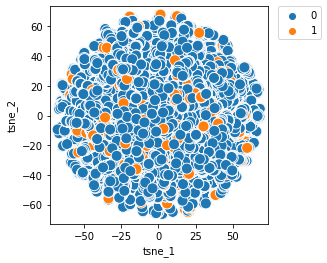

In [30]:
# Plot the result of our TSNE with the label color-coded, and 
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 
                               'tsne_2': tsne_result[:, 1], 
                               'label': target})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# Save the plot
plt.savefig('Figures/BERT_(1).png')